<hr style="border:10px solid gray">

# Simple running example of DAHSI

<hr style="border:2px solid gray">

⚠️ In order to run this notebook, you need to have installed all the dependancies needed to run DAHSI as listed in the $\texttt{README.md}$ file in this repository.

<hr style="border:2px solid gray">

⚠️ This notebook is for illustration of the method purposes only and so the toy problem chosen contains no hidden variables to be able to go through the code in a few minutes. This notebook will give you the tools and understanding necessary to be able to build your own problem and solve it using DAHSI.

ℹ️ To check an example of hidden variables, go to the `Example_LorenzSynth` folder in the github repo and explore the differences between `File1.txt` and `File2.txt` shown in this tutorial and the ones found in that folder.

<hr style="border:2px solid gray">

<hr style="border:10px solid gray">

## Table of contents

(Wait until the notebook is finalised to add the table of contents.)

1. [Generating the data](#Generating-the-data)
2. [Some paragraph](#)
    1. [Sub paragraph](#)
3. [Another paragraph](#)

<hr style="border:10px solid gray">

## Mathematical background 

The algorithm data assimilation for hidden sparse inference (DAHSI) boils down to minimising the following cost function:

\begin{equation}
    \label{costfunk}
        A(\mathbf{X},\mathbf{p}) = \frac{1}{N}\sum_{i=1}^N \Vert \mathbf{X}(t_{i}) - \mathbf{Y}(t_{i}) \Vert^2 + \frac{1}{N}\sum_{i=1}^{N-1} R_f \left\{ \Vert \mathbf{X}(t_{i+1}) - \mathbf{f}(\mathbf{X}(t_i),\mathbf{p},\mathbf{\hat{F}}) \Vert^2 \right\} + \lambda \Vert \mathbf{p} \Vert_1.        
\end{equation}

his function is composed of three terms: the experimental error, $A_E(\mathbf{X},\mathbf{Y}) = \frac{1}{N}\sum_{i=1}^N \Vert \mathbf{X}(t_{i}) - \mathbf{Y}(t_{i}) \Vert^2$, the model error term, $A_M(\mathbf{X},\mathbf{p},\mathbf{\hat{F}}) = \frac{1}{N}\sum_{i=1}^{N-1} \left\{ \Vert \mathbf{X}(t_{i+1}) - \mathbf{f}(\mathbf{X}(t_i),\mathbf{p},\mathbf{\hat{F}}) \Vert^2 \right\}$, and a sparse penalty term $\lambda \Vert \mathbf{p} \Vert_1$. Here, $\mathbf{f}(\mathbf{X}(t_i),\mathbf{p},\mathbf{\hat{F}}) = \mathbf{X}(t_{i+1})$ defines the discrete time model dynamics and is obtained by discretizing the governing equations using a Hermite-Simpson collocation.

For full details on our method, check out our paper <a href="https://doi.org/10.1063/5.0066066">here</a>.

<hr style="border:10px solid gray">

We first import all llibraries we will use throughout the notebook.

In [1]:
%matplotlib inline

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cyipopt
from termcolor import colored
from tqdm.notebook import tqdm_notebook
import time
import sys
import pickle 
import os
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7f98f86fee00>)

<hr style="border:10px solid gray">

## Generating the data 

We will work with the Lorenz system as it is a classical example of chaotic systems.

We numerically simulate the system using Runge-Kutta 4th order with $\Delta t = 0.01$ to obtain the <i>data</i> we will use to show a simple running example. We will consider $N = 501$ time points, and we will add to the <i>data</i> some normally distributed noise with $\omega = 0.01$.

We will save the time-series for each variable in $\texttt{.dat}$ files.

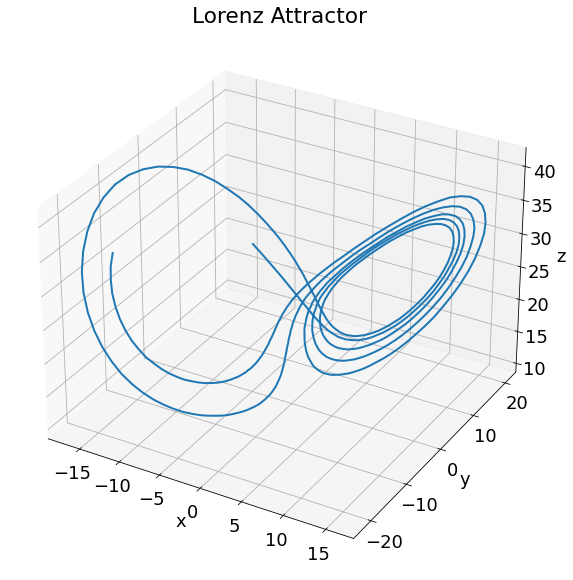

In [2]:
def RungeKutta4(f, t, y0, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], y[i], *args)
        k2 = f(t[i] + h / 2., y[i] + k1 * h / 2., *args)
        k3 = f(t[i] + h / 2., y[i] + k2 * h / 2., *args)
        k4 = f(t[i] + h, y[i] + k3 * h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

def Lorenz(t, y, sigma, rho, beta):
    return np.array([sigma * (y[1] - y[0]), 
                     y[0]*(rho - y[2]) - y[1], 
                     y[0]* y[1] - beta*y[2]])

y0 = [-8.0, 7.0, 27.0]
sigma = 10.0
rho = 28.0
beta = 8.0/3

dt = 0.01
N = 501
tfin = dt * (N - 1)
t = np.linspace(0, tfin, N)

sol = RungeKutta4(Lorenz, t, y0, args=(sigma,rho,beta))

# mean and standard deviation for the added Gaussian noise.
mu, sigma = 0, 0.01 
noise = np.random.normal(mu, sigma, size=(N, 3))

sol = sol + noise

x = sol[:,0]
y = sol[:,1]
z = sol[:,2]

xfile = open("datax_Lorenz.dat", "w")
yfile = open("datay_Lorenz.dat", "w")
zfile = open("dataz_Lorenz.dat", "w")

for i in range(N):
    xfile.write("%.5f\n" % x[i])
    yfile.write("%.5f\n" % y[i])
    zfile.write("%.5f\n" % z[i])

xfile.close()    
yfile.close()    
zfile.close()    

# plot the data we will use in DAHSI.
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 18})
ax = plt.figure().add_subplot(projection='3d')

ax.plot(x, y, z, lw=2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lorenz Attractor")

plt.show()    

<hr style="border:10px solid gray">

# A quick tour to the problem setup files

First we are going to look into how we define the generic equations, parameters, bounds etc. To do so, we will load `File1.txt` and go over each line.

In [3]:
with open('File1.txt', 'r') as f:
    for i, line in enumerate(f, start=1):
        print(colored('%.2d','green') % i, '%s' % line.strip())        

01 # Number of state variables, number of parameters, number of measured state variables, time step, number of time points.
02 3,30,3,0.01,501
03 # State variable names.
04 x
05 y
06 z
07 # Parameter names.
08 B101
09 B102
10 B103
11 B104
12 B105
13 B106
14 B107
15 B108
16 B109
17 B110
18 B201
19 B202
20 B203
21 B204
22 B205
23 B206
24 B207
25 B208
26 B209
27 B210
28 B301
29 B302
30 B303
31 B304
32 B305
33 B306
34 B307
35 B308
36 B309
37 B310
38 # Equations, in the same order as variables.
39 B101+B102*x+B103*y+B104*z+B105*x*x+B106*x*y+B107*x*z+B108*y*y+B109*y*z+B110*z*z
40 B201+B202*x+B203*y+B204*z+B205*x*x+B206*x*y+B207*x*z+B208*y*y+B209*y*z+B210*z*z
41 B301+B302*x+B303*y+B304*z+B305*x*x+B306*x*y+B307*x*z+B308*y*y+B309*y*z+B310*z*z
42 # Upper and lower bounds for the the state variables search (min,max).
43 -20,20
44 -30,30
45 0,50
46 # Upper and lower bounds for the parameter search (min,max).
47 -50,50
48 -50,50
49 -50,50
50 -50,50
51 -50,50
52 -50,50
53 -50,50
54 -50,50
55 -50,50


The first line contains the number of state variables (`num_vars`), parameters (`num_params`) and measured state variables (`num_meas`), the time step $\Delta t$ and the total number of time points (`num_tpoints`), in that order and separated by commas. In the example file above, we can see that our problem has 3 state variables, 30 parameter to estimate and $3$ measured state variables. Our data consists of 501 time steps, with a step size of 0.01.
    
The next lines assign names to our state variables, each name in one different line. The observed variables are written first, and the hidden variables after. In this case we do not consider any hidden variables. In the example file above, the variables are named $x$, $y$ and $z$.

The next lines assign names to the parameters we seek to estimate, each name in one different line. In the example provided, the parameter names are $Bk0j$, for $k=1,2,3$, and $j=1,\dots,10$. 
    
The next lines define the equations of our problem. One line for each equation. The equations have to be written in the same order as the state variables. For the three variables, we consider a library of monomials of the three variables up to degree two.
    
We now set the upper and lower bounds for the state variables, separated by a comma. One line for each state variable.
    
Finally, we also get the upper and lower bounds for the parameters, separated by a comma. One line for each parameter.

Next we will look into `File2.txt`, were we define what our data files are.

In [4]:
with open('File2.txt', 'r') as f:
    for i, line in enumerate(f, start=1):
        print(colored('%.2d','green') % i, '%s' % line.strip())     

01 # Data names.
02 datax
03 datay
04 dataz
05 # Data file names.extension
06 datax_Lorenz.dat
07 datay_Lorenz.dat
08 dataz_Lorenz.dat


This file contains the information about the measured state variables.
    
In the first lines we give names to the data of each measured state variable. One line for each measured state variable.
    
The next lines include the file name (and its extension) in which we can find the data of each measured variable. One line per measured variable, and in the same order as in the first part of the file.
    
In the example file above we have three measured state variables: we call them `datax` and `datay` and `dataz`; we then indicate that the data of our measured state variables can be found in `datax_Lorenz.dat`, `datay_Lorenz` and `dataz_Lorenz` files.

Finally, the variational annealing and model selection tuning parameters are defined in `File3.txt`.

In [5]:
with open('File3.txt', 'r') as f:
    for i, line in enumerate(f, start=1):
        print(colored('%.2d','green') % i, '%s' % line.strip())     

01 # alpha, beta_max.
02 2.0
03 30
04 # For lambda sweep, define lambda_min and lambda_max.
05 0.000001
06 68.00


The first two lines define values for $\alpha$ and $\beta_{\text{max}}$ for variational annealing. 
    
The next two lines indicate the initial $\lambda$ and the maximum value it can attain. This $\lambda$ value controls the sparsity of the models recovered. We should always start with one that includes all possible functions and set a maximum $\lambda$ for which all the terms drop to zero.
    
In the example file above we have set $\alpha = 2$ and a maximum $\beta$ value to 30. Initial $\lambda$ is set to $10^{-6}$ and the maximum to 68.

<hr style="border:10px solid gray">

# Compiling DAHSI

⚠️ It is **absolutely** necessary to run the following line of code. 

`compile.py` runs three crucial scripts that enable DAHSI to run:
* It first calculates the objective function, its Jacobian and Hessian for a general time point and saves them as strings. This is done via `Build_ObjJacHess.py`;
* The file `WriteStrings.py` is used to take the strings generated in the first point and and write them in the "blank template" `OneLoopInC_Blank.pyx`, which will create the functions for the objective function, its Jacobian and Hessian in *cython* format. The output is the file `OneLoopInC.pyx`;
* Finally, it runs the file `setup.py` to create a `build` directory, a C file (`.c`), and a Shared Object file (`.so`). With this, we will be able to import our C-extension into our code.

In [6]:
!python compile.py


Defining the objective function...

	It takes 0.285011 seconds to create the objective function for a general time point.


Defining the Jacobian...

	It takes 1.579902 seconds to create the Jacobian for a general time point.


Defining the Hessian...

	It takes 11.794024 seconds to create the Hessian for a general time point.

	There's a total of 55011 non-zeros in the full Hessian.


Total time: 15.383448 seconds.


	The strings were successfully written in the Cython file.

running build_ext
cythoning OneLoopInC.pyx to OneLoopInC.c
building 'OneLoopInC' extension
creating build
creating build/temp.linux-x86_64-3.9
gcc -pthread -B /home/user/anaconda3/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/user/anaconda3/include -I/home/user/anaconda3/include -fPIC -O2 -isystem /home/user/anaconda3/include -fPIC -I/home/user/anaconda3/include/python3.9 -c OneLoopInC.c -o build/temp.linux-x86_64-3.9/OneLoopInC.o -ffast-math
gcc -pthread -B /home/

Next, we load the variables needed from `ObjNeed.obj` created in `Define_JacHess.py`. We only need the variables `row_final` and `col_final`, but by the nature of the `pickle` library, we need to unload all the objects that were pickled into the file before the ones we need. `Define_JacHess.py` is the file in which we find expressions for the cost function, its Jacobian and its Hessian. Open said file to see the code thouroughly commented.

In [7]:
file_ObjJacHess = open('ObjJacHess.obj', 'rb') 

ObjFunk_Meas_eval = pickle.load(file_ObjJacHess)
ObjFunk_Model_eval = pickle.load(file_ObjJacHess)
Jacobian_Meas = pickle.load(file_ObjJacHess)
Jacobian_Model = pickle.load(file_ObjJacHess)
Hessian_Meas = pickle.load(file_ObjJacHess)
Hessian_Model = pickle.load(file_ObjJacHess)
row_final = pickle.load(file_ObjJacHess)
col_final = pickle.load(file_ObjJacHess)
nnzh = pickle.load(file_ObjJacHess)

We now can import all the modules and functions needed to run our code.

In [8]:
# Read_Files.py reads the three input text files (File1.txt, File2.txt and File3.txt).
from Read_Files import *

# Obj_Funks defines the measured and model part of the action we are minimising.
from Obj_Funks import Meas_Funk
from Obj_Funks import Model_Funk

# We import the cost function, Jacobian and Hessian functions.
import OneLoopInC
from OneLoopInC import eval_f_tricky
from OneLoopInC import eval_grad_f_tricky
from OneLoopInC import eval_h_tricky

Finally we define a class (called DAHSI) that contains the objective function, the Jacobian and the Hessian, and define the constrains of the problem as empty.

In [9]:
class DAHSI():
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return eval_f_tricky(x,Rf)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        return np.transpose(eval_grad_f_tricky(x,Rf))

    def constraints(self, x):
        """Returns the constraints."""
        return array([ ], float_)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return np.array([])

    # Location of the non-zero elements of the Hessian.
    def hessianstructure(self):
        """Returns the row and column indices for non-zero values of the
        Hessian."""
 
        return (np.array(col_final),np.array(row_final))

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""        
        H = eval_h_tricky(x,lagrange,obj_factor,0,Rf)        

        row, col = self.hessianstructure()

        return H

<hr style="border:10px solid gray">

# Setting up the initial conditions

In [10]:
# Choose seed for random number generation.
IC = 0
np.random.seed(IC)

Use appropriate initial conditions: for observed state variables, the data provided; for hidden state variables, random; for parameters, set them all to 0.

In [11]:
# Bounds for both state variables and parameters. 
x_L = np.ones((num_total))
x_U = np.ones((num_total))

for i in range(num_vars):
    x_L[i:-num_params:num_vars] = float(Input1[1+2*num_vars+num_params+i].split(",")[0])
    x_U[i:-num_params:num_vars] = float(Input1[1+2*num_vars+num_params+i].split(",")[1])
for i in range(num_params):
    x_L[-num_params+i] = float(Input1[1+3*num_vars+num_params+i].split(",")[0])
    x_U[-num_params+i] = float(Input1[1+3*num_vars+num_params+i].split(",")[1])
    
# Initial vector.    
x0 = (x_U-x_L)*np.random.rand(num_total)+x_L      
for i in range(num_meas):
    for k in range(0,num_vars*num_tpoints,num_vars):
        x0[k+i] = data[int(k/num_vars),i] 
for i in range(num_params):    
    x0[i-num_params] = 0
        
x_jp = np.zeros((num_total))    
for i in range(num_total):
    x_jp[i] = x0[i]    

Define the problem using cyipopt (the Python wrapper around Ipopt). We also can adjust some parameters for Ipopt iself.

In [12]:
nlp = cyipopt.Problem(n = num_total, 
                      m = 0, 
                      problem_obj = DAHSI(), 
                      lb = x_L, 
                      ub = x_U, 
                      cl = np.array([]), 
                      cu = np.array([]))

# Change some options of the Ipopt solver.
nlp.add_option('linear_solver', 'ma97')
#nlp.add_option('max_iter',100)
#nlp.add_option('tol',1.e-12)
nlp.add_option('mu_strategy', 'adaptive')
nlp.add_option('adaptive_mu_globalization', 'never-monotone-mode')
# nlp.add_option('bound_relax_factor', 0)
nlp.add_option('print_level',0)

<hr style="border:10px solid gray">

# Running the $\lambda$ sweep

The core of the DAHSI algorithm is a nonlinear optimization step using VA, which is randomly initialized. At each VA step, we minimize $A_E+R_f A_M$ over state variable trajectories $\mathbf{X}(t)$ and parameters $\mathbf{p}$ given $R_f$ using IPOPT interfaced here via cyipopt.

Now we start the loop on $\lambda$. We start with a very small $R_f$ value and increase it as the VA step. We do this for every $\lambda$ we want to study.

In [13]:
lambd = lambd_0

file_name = "D%s_M%s_IC%s_Lorenz.dat" % (num_vars, num_meas, IC) 
file_results = os.path.join("outputfiles",file_name)
f = open(file_results,"w+")

print(colored('Variatonal annealing for different \lambda.', attrs=['bold']))
iter_count = 1
# Here starts the main loop
while lambd < lambd_max:   
    f = open(file_results,"a+")

    Rf0 = 1e-2

    for i in range(num_total):
        x_jp[i] = x0[i]    

    print("Iteration #%d: \lambda = %f"%(iter_count,lambd))
    for beta in tqdm_notebook(range(beta_max+1)):
        f = open(file_results,"a+")
        # Make note in results file which \lambda and \beta we are at.
        f.write("%f %f " % (lambd, beta))        

        # Controlling how much the model is enforced.
        Rf = Rf0*(alpha**beta)
  
        # Solve it via IPOPT (solution is x_jn).    
        x_jn, info = nlp.solve(x_jp)
            
        obj = info['obj_val']
        
        # We hard threshold the parameter part of the solution (the last num_params elements).
        for i in range(num_params):
            if abs(x_jn[i-num_params]) < lambd:
                x_jn[i-num_params] = 0

        # We set this solution as the initial condition for the next iteration of IPOPT. 
        x_jp = x_jn   

        # Write cost function value in file.
        f.write("%e " % obj)
                
        for k in range(num_params):
            f.write("%f " % x_jp[k-num_params])
        f.write("\n")     
        
        f.close()

    # Increase \lambda value.       
    lambd = 2*lambd
    iter_count = iter_count+1
f.close()   

num_lambda = iter_count-1

Variatonal annealing for different \lambda.
Iteration #1: \lambda = 0.000001


  0%|          | 0/31 [00:00<?, ?it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Iteration #2: \lambda = 0.000002


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #3: \lambda = 0.000004


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #4: \lambda = 0.000008


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #5: \lambda = 0.000016


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #6: \lambda = 0.000032


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #7: \lambda = 0.000064


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #8: \lambda = 0.000128


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #9: \lambda = 0.000256


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #10: \lambda = 0.000512


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #11: \lambda = 0.001024


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #12: \lambda = 0.002048


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #13: \lambda = 0.004096


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #14: \lambda = 0.008192


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #15: \lambda = 0.016384


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #16: \lambda = 0.032768


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #17: \lambda = 0.065536


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #18: \lambda = 0.131072


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #19: \lambda = 0.262144


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #20: \lambda = 0.524288


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #21: \lambda = 1.048576


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #22: \lambda = 2.097152


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #23: \lambda = 4.194304


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #24: \lambda = 8.388608


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #25: \lambda = 16.777216


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #26: \lambda = 33.554432


  0%|          | 0/31 [00:00<?, ?it/s]

Iteration #27: \lambda = 67.108864


  0%|          | 0/31 [00:00<?, ?it/s]

<hr style="border:10px solid gray">

# Basic analysis of the results

NOTE: at the moment I just put these two figures without commenting the results and we can talk about which plots make sense to put and which not in our next meeting to finalise this section.

In [14]:
output_file = np.loadtxt('outputfiles/D3_M3_IC0_Lorenz.dat', unpack = False)

In [15]:
# for ll in range(num_lambda):
#     print((ll)*beta_max+ll,(ll+1)*(beta_max)+(ll))
# #     print(output_file[(ll)*beta_max+ll,:])
# #     print(output_file[(ll+1)*beta_max+ll,:])

# # output_file[-1,:]

In [16]:
# ax = plt.figure()
# plt.semilogy(beta, obj, 'bo', markersize=10)

# plt.rcParams["figure.figsize"] = (12,10)
# plt.rcParams.update({'font.size': 18})

# plt.xlabel("\\beta")
# plt.ylabel("log(action)")
# # ax.set_title("")

# plt.grid(True)

# plt.show()

In [17]:
sub_array = output_file[1::,0:3]

# Convert result file into first data frame with lambda, beta and action values.
columns = ["lambda", "beta", "action"]
df_1 = pd.DataFrame(data=sub_array, columns=columns)

# print(df_1.head())

# Convert result file into lambda, active terms.
table_active_terms = np.zeros((num_lambda,3))
for ll in range(num_lambda):
#     print((ll)*beta_max+ll,(ll+1)*(beta_max)+(ll))
    active_terms = 0
    for i in range(num_params):
        if output_file[(ll+1)*beta_max+ll,3+i] != 0:
            active_terms = active_terms+1
    table_active_terms[ll,0] = output_file[(ll+1)*beta_max+ll,0]
    table_active_terms[ll,1] = active_terms
    table_active_terms[ll,2] = active_terms*100
columns_2 = ["lambda", "active terms", "size"]
df_2 = pd.DataFrame(data=table_active_terms, columns=columns_2)

# print(df_2.head())

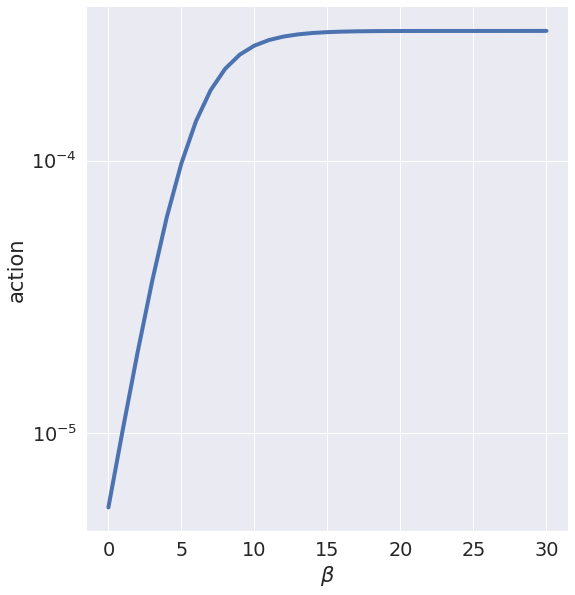

In [18]:
sns.set_theme()

sns.set(font_scale=1.75)

g = sns.relplot(
    data=df_1, kind="line",
    x="beta", y="action", #col="lambda",
#     hue="lambda", style="lambda",
    linewidth = "4",
    facet_kws=dict(sharex=False),
)

g.set_xlabels('$\\beta$', clear_inner=False)
g.set_ylabels('action', clear_inner=False)
g.set(yscale="log")
g.fig.set_size_inches(12,10)

Comment the figure above.

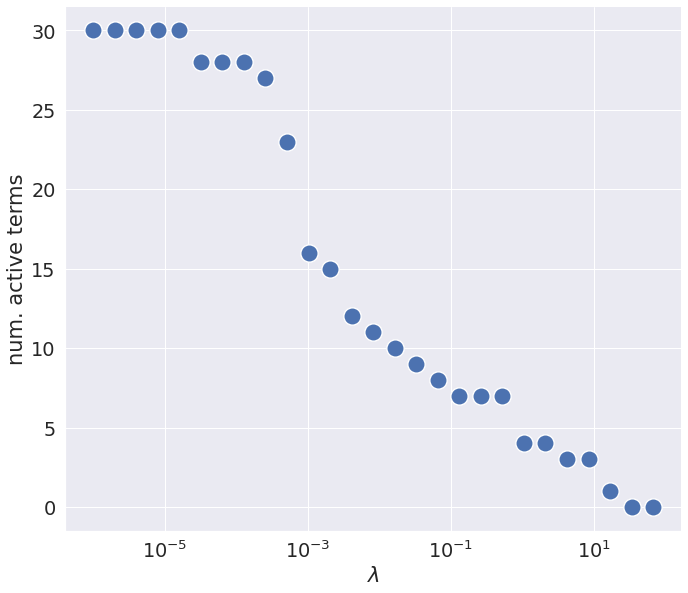

In [19]:
sns.set(font_scale=1.75)

# sns.stripplot(x = 'Pos', y = 'Weight', data = wnba, jitter = True)


g = sns.relplot(
    data=df_2,
    x="lambda", y="active terms",
#     hue="active terms", #style="smoker", size="size",
    s=300,
)

# g.set_titles("")
g.set_xlabels('$\lambda$', clear_inner=False)
g.set_ylabels('num. active terms', clear_inner=False)
g.set(xscale="log")
g.fig.set_size_inches(12,10)
# g.fig.savefig("seaborntest.eps", close = True, verbose = True)

Comment the figure above.

In [20]:
# columns = ["beta", "action"]
# for ll in range(num_lambda):
#     table_actions = np.zeros((beta_max+1,2))
#     table_actions[:,0] = range(31)
#     table_actions[:,1] = output_file[(ll)*beta_max+ll:(ll+1)*(beta_max)+(ll)+1,2]
#     df_3 = pd.DataFrame(data=table_actions, columns=columns)

#     sns.set(font_scale=1.75)

#     g = sns.scatterplot(
#         data=df_3,
#         x="beta", y="action",
# #         hue="beta", #style="smoker", size="size",
#         s=300,
#     )

#     plt.title("Action path for different $\lambda$")
#     plt.xlabel('$\\beta$')
#     plt.ylabel('action')
#     plt.ylim([1e-6,1e-3])
#     g.set(yscale="log")